# Python imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set("talk") 
import scipy.stats as stats
from cycler import cycler
from matplotlib.cm import get_cmap
import emcee
import corner
from IPython.display import display, Math
import pandas

## The Data

In [2]:
# Reading in the data
names = ['x_data', 'y_data', 'dy_data']
url = "https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat"
print('Table III')
data = pandas.read_csv(url, names=names, sep='\t+', engine='python', comment='#')
display(data)

Table III


,x_data,y_data,dy_data
0,0.03183,0.31694,0.015850
1,0.06366,0.33844,0.016920
2,0.09549,0.42142,0.021070
3,0.12732,0.57709,0.028850
4,0.15915,0.56218,0.028110
5,0.19099,0.68851,0.034430
6,0.22282,0.73625,0.036810
7,0.25465,0.87270,0.043640
8,0.28648,1.00150,0.050075
9,0.31831,1.06840,0.053420


In [3]:
x_data = data['x_data'].to_numpy()
y_data = data['y_data'].to_numpy()
dy_data = data['dy_data'].to_numpy()
print(x_data)
print(y_data)
print(dy_data)

[0.03183 0.06366 0.09549 0.12732 0.15915 0.19099 0.22282 0.25465 0.28648
 0.31831]
[0.31694 0.33844 0.42142 0.57709 0.56218 0.68851 0.73625 0.8727  1.0015
 1.0684 ]
[0.01585  0.01692  0.02107  0.02885  0.02811  0.03443  0.03681  0.04364
 0.050075 0.05342 ]


In [10]:
#The function chosen in section III. DIAGNOSTICS AND PROCEDURES FOR PARAMETER ESTIMATION
def g_fun(x_points, percent_error_ = 0.05):
    noise = (1.0 + stats.norm.rvs(0.0, percent_error_, size=np.size(x_points)))
    return ((0.5 + np.tan(np.pi * x_points / 2.))**2) * noise

In [16]:
def y_model(x_pts, theta, order=None):
    values = []
    if order is None:
        order = np.size(theta)
    for x_points in x_pts:
        value = 0
        for i in range(order):
            value += theta[i]*x_points**i
        values.append(value)
    values = np.array(values)
    return values

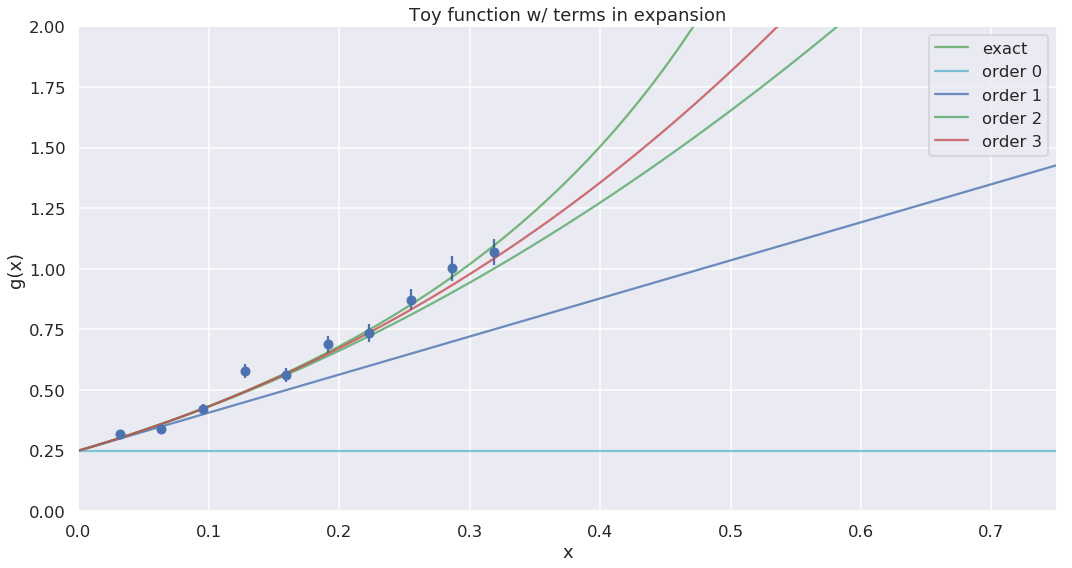

In [17]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x_data, y_data, dy_data, fmt='o')
ax.set_xlabel(r'x')
ax.set_ylabel(r'g(x)')
ax.set_xlim(0, 0.75)
ax.set_ylim(0, 2)
theta_true = np.array([0.25, 1.57, 2.47, 1.29, 4.06,1.28, 5.67])
x_points = np.arange(0., 1., .01)
ax.plot(x_points, g_fun(x_points, percent_error_=0), color='green', alpha=0.5, label='exact')
ax.set_title('Toy function w/ terms in expansion')
colors = ['c', 'b', 'g', 'r', 'm', 'k', 'p']

num_dim = 4
for order in range(num_dim):
    ax.plot(x_points, y_model(x_points, theta_true[:num_dim], order+1), label=f'order {order:d}', color=colors[order], alpha=0.8)
ax.legend()

fig.tight_layout()

## Model

In [18]:
def log_likelihood(x_data, y_data, dy, theta):
    y_itheory = y_model(x_data, theta)
    return -0.5 * np.sum( np.log(2 * np.pi * dy ** 2) +
                          (y_data - y_itheory) ** 2 / dy ** 2)

def log_uniform_prior(theta, a_max=500.):
    if np.all(np.abs(theta) <= a_max):        
        return 0
    else:
        return -np.inf

def log_gaussian_prior(theta, a_bar=5.):
    value = 0
    for i in np.arange(0,np.size(theta)):
        value += -0.5*((i+1)*np.log(2*np.pi*a_bar**2) + theta[i]**2/a_bar**2)
    
    return value

def log_posterior(theta, x_data, y_data, dy, log_prior=log_gaussian_prior):
    return log_prior(theta) + log_likelihood(x_data, y_data, dy, theta)



## Results

In [22]:
def example_posterior(num_dim, n_walkers=50, n_steps=1500, prior=log_gaussian_prior, output=True):
    
    n_burn = 1000  
    starting_guesses = np.random.rand(n_walkers,num_dim)
    #     starting_guesses = np.random.rand(nwalkers,ndim)
    sampler = emcee.EnsembleSampler(n_walkers, num_dim, log_posterior, args=[x_data, y_data, dy_data, \
                                                                           log_gaussian_prior])
    
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_burn)
    sampler.reset()
    
    sampler.run_mcmc(pos, n_steps)
    
    text = "Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),n_walkers*n_steps)
    if output==True:
        print(text)
    
    samples = sampler.chain.reshape((-1, num_dim))
    
    return samples, starting_guesses, sampler

In [23]:
def corner_plot(samples, num_dim, theta_true):
    label_corners = []
    for q in range(num_dim):
        labels = f'a{q}'
        label_corners.append(labels)
    fig = corner.corner(samples, labels=label_corners, 
                        truths=theta_true[:num_dim], quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 16})
    
def quantiles(num_dim, samples):
    upper = np.zeros(num_dim)
    middle = np.zeros(num_dim)
    lower = np.zeros(num_dim)
    for i in range(num_dim):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        lower[i], upper[i]  = np.diff(mcmc)
        middle[i] = mcmc[1]
    return middle, upper, lower

Mean acceptance fraction: 0.594 (in total 75000 steps)


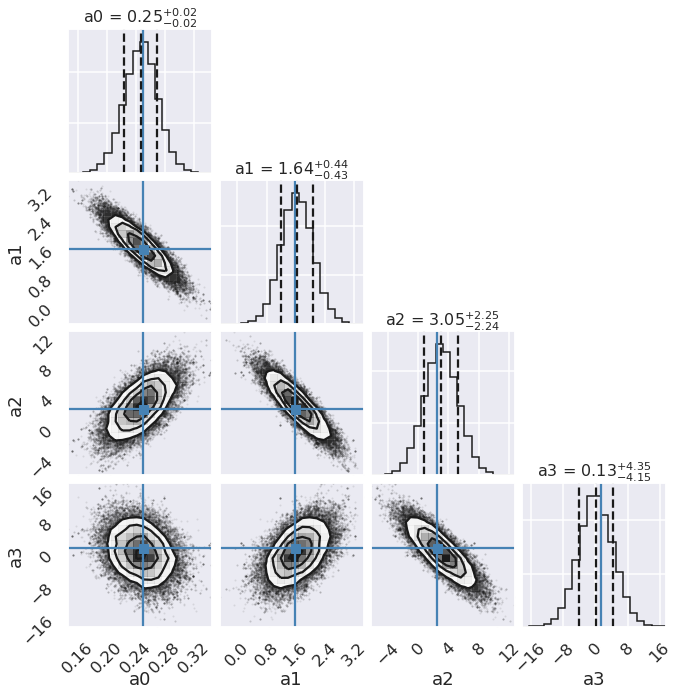

In [24]:
num_dim = 4
samples, start_guesses, sampler = example_posterior(num_dim) 
corner_plot(samples, num_dim , theta_true)

## Table III 

In [25]:
# Uniform prior
print('Uniform prior  in the format: k_max, a0, a1, a2, a3')
for num_dim in np.arange(1,8):
    samples, dummy1, dummy2 = example_posterior(num_dim, prior=log_uniform_prior, output=False) 
    middle, upper, lower = quantiles(num_dim, samples)
    k_max = num_dim - 1
    for i in np.arange(num_dim):
        if (i == 3):
            break
        print(f'{middle[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end='')
    print()

# Gaussian prior
print('Gaussian prior  in the format k_max, a0, a1, a2, a3')
for num_dim in np.arange(1,8):
    samples, dummy1, dummy2 = example_posterior(num_dim, prior=log_uniform_prior, output=False) 
    middle, upper, lower = quantiles(num_dim, samples)
    k_max = num_dim - 1
    print(f'{k_max} ', end='')
    for i in np.arange(num_dim):
        if (i == 3):
            break
        print(f'{middle[i]:.2f}+{upper[i]:.2f}-{lower[i]:.2f} ', end='')
    print()

Uniform prior  in the format: k_max, a0, a1, a2, a3
0.48+0.01-0.01 
0.20+0.01-0.01 2.55+0.11-0.10 
0.25+0.02-0.02 1.62+0.39-0.38 3.16+1.27-1.25 
0.25+0.02-0.02 1.65+0.44-0.45 2.95+2.30-2.34 
0.25+0.02-0.02 1.65+0.45-0.46 2.92+2.39-2.37 
0.25+0.02-0.02 1.66+0.45-0.47 2.90+2.44-2.35 
0.25+0.02-0.02 1.64+0.45-0.45 2.86+2.45-2.27 
Gaussian prior  in the format k_max, a0, a1, a2, a3
0 0.48+0.01-0.01 
1 0.20+0.01-0.01 2.55+0.11-0.10 
2 0.25+0.02-0.02 1.61+0.39-0.39 3.19+1.27-1.28 
3 0.25+0.02-0.02 1.65+0.45-0.46 2.92+2.33-2.32 
4 0.25+0.02-0.02 1.61+0.47-0.45 3.15+2.34-2.39 
5 0.25+0.02-0.02 1.68+0.45-0.47 2.87+2.37-2.31 
6 0.25+0.02-0.02 1.66+0.43-0.47 2.97+2.40-2.36 
